# Applying OT-intNMF to PBMC

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Plotting
import matplotlib.pyplot as plt

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
# Maths
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import torch
from torch import optim
from umap import UMAP

In [5]:
# Progress bar
from tqdm.notebook import tqdm

## Load data

Load the preprocessed PBMC dataset from 10X Genomics (scRNA-seq + scATAC-seq).

In [6]:
mdata = mu.read_h5mu('../datasets/PBMC_10k/preprocessed/pbmc10k.h5mu.gz')

In [7]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Select highly variable features

For computational reasons, in this demonstration we reduce the number of features.

In [ ]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=1000)
sc.pp.highly_variable_genes(atac, min_mean=3e-5, max_mean=5e-4, min_disp=0.7, n_top_genes=1000)

1000

## Subsample

In [ ]:
# Get the RNA and ATAC AnnData objects.
rna, atac = mdata.mod['rna'], mdata.mod['atac']

# Perform the subsampling.
sc.pp.subsample(rna, n_obs=800, random_state=0)
sc.pp.subsample(atac, n_obs=800, random_state=0)

# Create a MuData object with rna and atac.
mdata = mu.MuData({'rna': rna, 'atac': atac})

# Take the intersection.
mu.pp.intersect_obs(mdata)

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

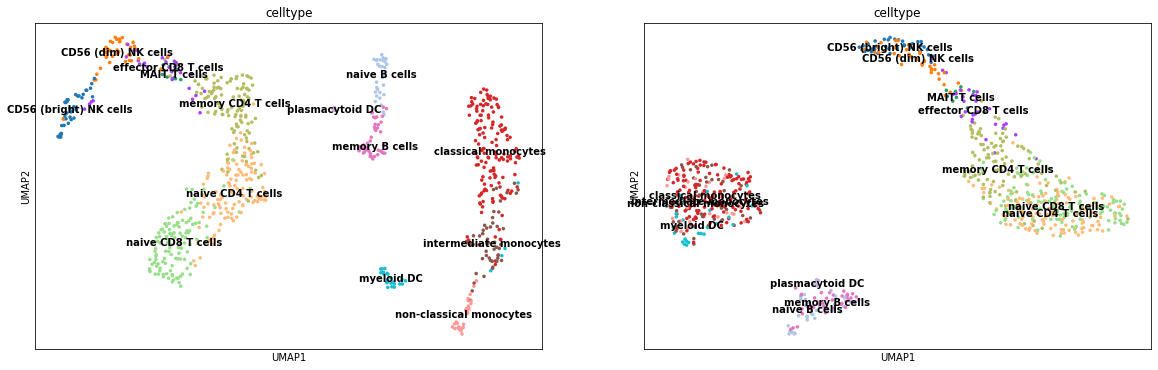

In [56]:
# Umap RNA
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)

# Umap ATAC
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)

# Display UMAP
fig, axes = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(20)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50, show=False, ax=axes[0])
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50, show=False, ax=axes[1])
plt.show()

## Perform NMF

Let us define the model and perform the dimensionaly reduction.

In [14]:
# Set the hyperparameters.
eps = .05
latent_dim = 15
rho_h = 5e-2
rho_w = 5e-2

In [15]:
# Define the model.
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='cosine')

In [16]:
# Perform the training.
nmf.fit_transform(mdata, max_iter_inner=2_000, max_iter=100, device='cpu', dtype=torch.float, lr=1, tol_inner=1e-12, tol_outer=1e-5, optim_name='lbfgs')

 22%|██▏       | 44/200 [45:20<2:40:43, 61.82s/it, loss=0.15465496, loss_inner=-0.39061746, inner_steps=780, gpu_memory_allocated=0]


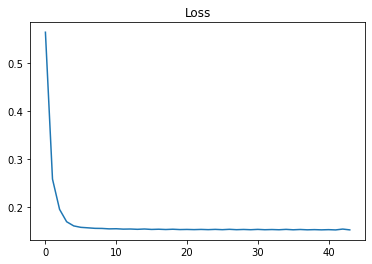

In [27]:
# Display training loss.
plt.title('Loss')
plt.plot(nmf.losses)
plt.show()

## Visualize the embedding

Now, let us display the obtained embedding.

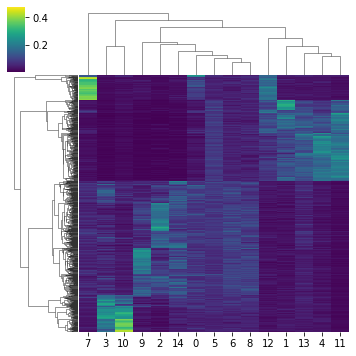

In [29]:
# First, using a dendogram.
pl.clustermap(mdata, 'W_OT', yticklabels=False, figsize=(5, 5))

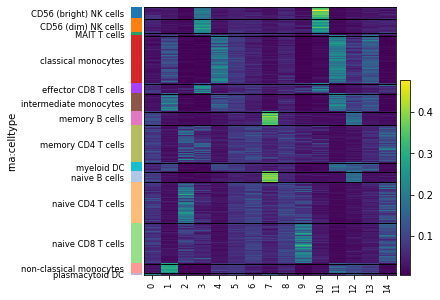

In [32]:
# Then, using the ground truth clusters.
pl.heatmap(mdata, 'W_OT', 'rna:celltype', figsize=(5, 5))

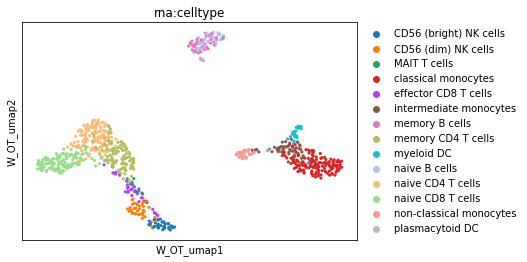

In [33]:
# Finally, we can compute an UMAP embedding and display it.
tl.umap(mdata, 'W_OT', metric='l1', min_dist=.6, spread=1)
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Analyse a given factor

We can zoom in on a particular factor to interpret it biologically.

In [48]:
# Display the 3 highest contributors to dimension 10, for RNA-seq.
tl.top_features(mdata, 'rna', 'H_OT', dim=10, n_features=5)

['GNLY', 'MCTP2', 'NKG7', 'PRF1', 'KLRD1']

In [44]:
# Query g:profiler for Gene Set Enrichment Analysis, and display the results for dimension 10.
enr, _ = tl.enrich(mdata, 'rna', n_genes=100, ordered=True)
enr[enr['query'] == 'dimension 10'].head()[['source', 'name', 'p_value']]

,source,name,p_value
2,GO:MF,MHC class Ib receptor activity,2.411305e-07
4,GO:BP,natural killer cell mediated immunity,3.019033e-07
5,GO:BP,regulation of natural killer cell mediated imm...,4.292099e-07
7,GO:CC,cytolytic granule,8.855396e-07
12,GO:BP,cell killing,6.883473e-06


Dimension 10 seems to be associated to Natural Killers. Let us test that by comparing to the existing annotation.

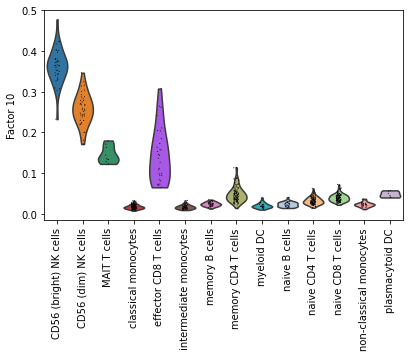

In [43]:
# Display a violin plot of the value at dimension 10 of the cells.
pl.factor_violin(mdata, groupby='rna:celltype', dim=10, rotation=90)

## Clustering

We can perform clustering on the lower-dimensional space.

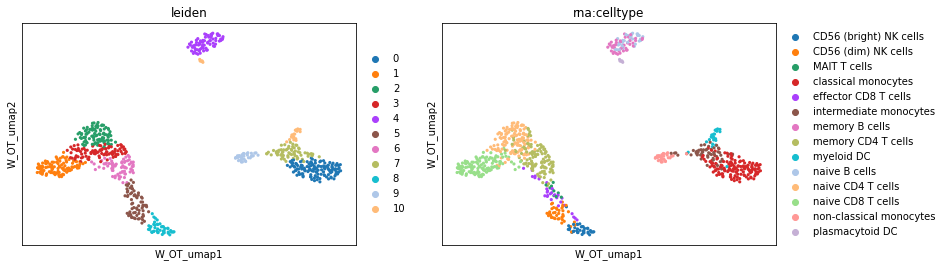

In [45]:
tl.leiden(mdata, resolution=1)
mu.pl.embedding(mdata, 'W_OT_umap', ['leiden', 'rna:celltype'], size=40)

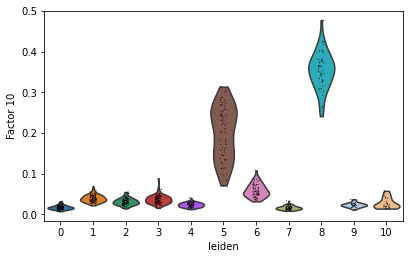

In [54]:
# Display a violoin plot of the value at dimension 10 of the cells.
pl.factor_violin(mdata, groupby='leiden', dim=10)